In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString
from scipy import ndimage, array, interpolate
from matplotlib import pyplot as plt
import numpy as np

In [2]:

# the node names here are irrelevant
#brighton_streets = gpd.read_file("../../data/brighton/brighton_streets.shp").to_crs("EPSG:26919")
brighton_sidewalks = gpd.read_file("../../data/brighton/brighton_sidewalks_diditwork.shp")

crs_global = "EPSG:4326"
crs_local = "EPSG:26919"
brighton_sidewalks.crs

<Projected CRS: EPSG:26919>
Name: NAD83 / UTM zone 19N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 72°W to 66°W and NAD83 by country
- bounds: (-72.0, 14.92, -66.0, 84.0)
Coordinate Operation:
- name: UTM zone 19N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
def round_pt(pt):
    a, b = pt
    a = round(a,1)
    b = round(b,1)
    return Point(a,b)

def round_edge(edge):
    if type(edge) == MultiLineString:
        edges = edge.geoms
        return MultiLineString(list(map(round_edge, edges)))
    else:
        return LineString(map(round_pt, list(edge.coords)))

from shapely.ops import linemerge

def safe_linemerge(line):
    if type(line) == MultiLineString:
        return linemerge(line.geoms)
    else:
        return line

def safe_pre_explode(line):
    if type(line) == MultiLineString:
        return line.geoms
    else:
        return line
    
def safe_explode(gdf):
    rows = []
    old_rows =[]
    for i, row in gdf.iterrows():
        if type(row['geometry']) == MultiLineString:
            mline = row.geometry
            for line in mline:
                new_row = row
                new_row.geometry = line
                rows.append(new_row)
                old_rows.append(i)
            
    new_gdf = gpd.GeoDataFrame(rows)
    new_gdf.crs = "EPSG:26919"
    gdf = gdf.drop(old_rows)
    gdf = gdf.append(new_gdf)
    return gdf
 

In [4]:
brighton_sidewalks.geometry = brighton_sidewalks.geometry.map(round_edge)
brighton_sidewalks = safe_explode(brighton_sidewalks).reset_index(drop=True)

In [5]:
# Thank you Sean Gilles https://gist.github.com/sgillies/465156#file_cut.py
from shapely.geometry import LineString, Point
from copy import deepcopy
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
        

# here's me
def recursive_cut(line, distance):
    if [line] == cut(line, distance):
        return [line]
    else:
        segment, rest = cut(line, distance)
        return [segment] + recursive_cut(rest, distance)
    
           
def list_explode(gdf):
    rows = []
    old_rows = []
    for i, row in gdf.iterrows():
        mline = row['cut_geometry']
        new_rows = [deepcopy(row) for i in range(len(row['cut_geometry']))]
        for n, inline in enumerate(mline):
            new_rows[n]['geometry'] = inline
            old_rows.append(i)
        rows.extend(new_rows)
    new_gdf = gpd.GeoDataFrame(rows).reset_index(drop=True)
    new_gdf.crs = "EPSG:26919"
    return new_gdf


In [6]:
import rasterio
dataset = rasterio.open("../../data/brighton/elevation.tif")

In [7]:
dataset.crs, dataset.bounds #hell yeah

(CRS.from_epsg(4326),
 BoundingBox(left=-72.00013888888888, bottom=41.99986111111111, right=-70.9998611111111, top=43.000138888888884))

In [8]:
# get the first "band"
# this is a numpy array
# now dataset.index(lat, lon) gives the array index for that point
band1 = dataset.read(1)


In [9]:
# need to flip lngs because the top of the image has greater lng
lats = np.arange(dataset.bounds.left, dataset.bounds.right, (dataset.bounds.right - dataset.bounds.left)/3601)
lngs = np.arange( dataset.bounds.top, dataset.bounds.bottom, -(dataset.bounds.top - dataset.bounds.bottom)/3601)

fn = band1 #array([band1[x,y] for x in range(3601) for y in range(3601)])

new_x = np.arange(dataset.bounds.left, dataset.bounds.right, (dataset.bounds.right - dataset.bounds.left)/360100)
new_y = np.arange(dataset.bounds.bottom, dataset.bounds.top, (dataset.bounds.top - dataset.bounds.bottom)/360100)

# takes lat lng and gives interpolated height
interp_elev = interpolate.interp2d(lats, lngs, band1, kind='cubic')

<function matplotlib.pyplot.show(*args, **kw)>

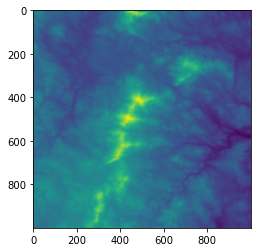

In [10]:
interp_elev(-72, 42), band1[dataset.index(-72, 42)]
plt.imshow(band1[0:1000, 0:1000])
plt.show
# compare with interp

In [11]:
def get_elev(lat, lon):
    return interp_elev(lat,lon)[0]

In [12]:
brighton_sidewalks['cut_geometry'] = brighton_sidewalks.geometry.map(lambda x : recursive_cut(x, 2))
brighton_sidewalks = list_explode(brighton_sidewalks)
brighton_sidewalks = brighton_sidewalks.to_crs(crs_global)



In [13]:
# get elevations

brighton_sidewalks['elevation_0'] = brighton_sidewalks.geometry.map(lambda x : get_elev(x.coords[0][0], x.coords[0][1]))
brighton_sidewalks['elevation_1'] = brighton_sidewalks.geometry.map(lambda x : get_elev(x.coords[1][0], x.coords[1][1]))

In [14]:
def get_slope(row):
    rise = row['elevation_1'] - row['elevation_0']
    run = row['length_m']
    return rise/run

In [15]:
from math import atan, pi
#brighton_sidewalks.drop(inplace=True, columns=['cut_geometry'])
brighton_sidewalks = brighton_sidewalks.to_crs(crs_local)
brighton_sidewalks['length_m'] = brighton_sidewalks.length
brighton_sidewalks = brighton_sidewalks[brighton_sidewalks.length != 0]
brighton_sidewalks['slope'] = brighton_sidewalks.apply(get_slope, axis=1)
brighton_sidewalks['angle_deg'] = brighton_sidewalks['slope'].map(lambda x : atan(x) * 360 / (2 * pi))

In [16]:
def is_steep(row):
    return (row['angle_deg'] > 5) or (row['angle_deg'] < -5)

len(brighton_sidewalks[(brighton_sidewalks['angle_deg'] > 5) | (brighton_sidewalks['angle_deg'] < -5)])/len(brighton_sidewalks)

0.1440923023538257

In [17]:
brighton_sidewalks.drop(inplace=True, columns=['elevation_0','elevation_1','slope','cut_geometry'])
brighton_sidewalks = brighton_sidewalks.to_crs(crs_global)

In [18]:
import osmnx as ox
import networkx as nx

In [19]:
brighton_sidewalks = brighton_sidewalks.to_crs(crs_local)
brighton_sidewalks.geometry = brighton_sidewalks.geometry.map(round_edge)

In [20]:
# add routing
points = list(map(Point, (list(set([point for ls in list(brighton_sidewalks.geometry.map(lambda x : list(x.coords)).values) for point in ls])))))
brighton_sw_points = gpd.GeoDataFrame(points)
brighton_sw_points.geometry = brighton_sw_points[0]
len_sw = len(list(brighton_sw_points.geometry.map(lambda x : x.coords)))
sw_coord_dict = dict(list(set(zip(list(brighton_sw_points.geometry.map(lambda x : tuple(x.coords)[0])), range(len_sw)))))
sw_coords = sw_coord_dict.keys()

from shapely.coords import CoordinateSequence
brighton_sidewalks['u'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sidewalks['v'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[-1]])
brighton_sidewalks['key'] = 0

brighton_sw_points['id'] = brighton_sw_points.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sw_points['osmid'] = brighton_sw_points.id
brighton_sidewalks['osmid'] = brighton_sidewalks.index.map(lambda x : 1000000000 * x)

In [21]:
brighton_sidewalks = brighton_sidewalks.to_crs(crs_global)
brighton_sw_points.crs = crs_local

brighton_sw_points = brighton_sw_points.to_crs(crs_global)
brighton_sw_points['x'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][1])
brighton_sw_points['y'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][0])

In [22]:
def get_angle_class(angle):
    angle = abs(angle)
    if angle < 1:
        return 0
    elif angle < 2:
        return 1
    elif angle < 3:
        return 2
    elif angle < 4:
        return 3
    else:
        return 4
brighton_sidewalks['angle_class'] = brighton_sidewalks['angle_deg'].map(get_angle_class)

In [23]:
import pickle as pkl

with open('../../data/brighton/brighton_sidewalks_only.pkl', 'wb') as pklfile:
    pkl.dump(brighton_sidewalks, pklfile)

In [24]:
def union_graph(points_gdfs, edges_gdfs, crs=None):
    points_df = pd.concat([pd.DataFrame(gdf) for gdf in points_gdfs], ignore_index=True, sort=False)
    edges_df = pd.concat([pd.DataFrame(gdf) for gdf in edges_gdfs], ignore_index=True, sort=False)
    
    if crs:
        points_gdf = gpd.GeoDataFrame(points_df, crs = points_gdfs[0].crs).to_crs(crs)
        edges_gdf = gpd.GeoDataFrame(edges_df, crs = edges_gdfs[0].crs).to_crs(crs)
    else:
        points_gdf = gpd.GeoDataFrame(points_df, crs = points_gdfs[0].crs)
        edges_gdf = gpd.GeoDataFrame(edges_df, crs = edges_gdfs[0].crs)
    return ox.utils_graph.graph_from_gdfs(points_gdf, edges_gdf)


brighton_G = union_graph([brighton_sw_points], [brighton_sidewalks])
#brighton_G = ox.utils_graph.get_largest_component(brighton_G,strongly=True)

In [25]:
import pickle as pkl
with open("../../data/brighton/brighton_graph_sidewalks_only.pkl", 'wb') as pklfile:
    pkl.dump(brighton_G, pklfile)

In [ ]:
import geocoder
g1 = geocoder.osm("32 Claymoss Rd, Boston, MA")
g2 = geocoder.osm("371 Washington St, Brighton, MA 02135")
g3 = geocoder.osm("90 monastery rd, Boston, MA")
p1 = Point(g1.json['lng'], g1.json['lat']).coords[0]
p2 = Point(g2.json['lng'], g2.json['lat']).coords[0]
p3 = Point(g3.json['lng'], g3.json['lat']).coords[0]
n1, d1 = ox.get_nearest_node(brighton_G, p1, method='haversine', return_dist=True)
n2, d2 = ox.get_nearest_node(brighton_G, p2, method='haversine', return_dist=True)
n3, d3 = ox.get_nearest_node(brighton_G, p3, method='haversine', return_dist=True)
p1, n1, d1, p2, n2, d2

In [ ]:
route = nx.shortest_path(brighton_G, n1, n2)
map1 = ox.plot_route_folium(brighton_G, route, route_width = 2)


In [ ]:
print(display(map1))

In [ ]:
map1.save('map.html')